# Introduction

This is the validation notebook for the PySAL implementation of the local join count (LJC) bivariate statistic. This notebook will begin with a brief review of the bivariate LJC and a manual calculation of the values on a 'toy' dataset. We will then introduce the PySAL implementation of the `Local_Join_Count_BV` function. Output from the `Local_Join_Count_BV` function will be compared to the results from the manual calculation on the 'toy' dataset. Following the 'toy' dataset will be a comparison of the PySAL `Local_Join_Count_BV` function to the external `GeoDa` results on an external dataset. As of now, calculations of inference are not included in the function.

1. [Review of the bivariate LJC statistic](#Review)
2. [Manual calculations on a 'toy' dataset](#Toy)
3. [Implementation of Local_Join_Count_BV function](#LJC)
4. [Application of Local_Join_Count_BV function on the 'toy' dataset](#LJCToy)
5. [Application of Local_Join_Count_BV function on 'real world' datasets](#LJCRealWorld)

## Review of the bivariate LJC statistic <a name="Review"></a>

To review, global join counts focus on the total number of adjacent counts of certain values across the entire study area.  This is represented as $BB$:

$$BB = \sum_{i} \sum_j w_{ij} x_{i} x_{j}$$

Of particular interest to us are the number of local black-black (1-1) join counts. This is represented as $BB_i$: 

$$ BB_i = x_i \sum_{j} w_{ij} x_j$$

...where a count of the neighbors with an observation of $x_j=1$ for those locations where $x_i=1$. This focuses on the BB counts of a given polygon (x_i).

When considering two variables, we extend the above equation to: 

$$ BJC = x_i (1 - z_i) \sum_{j} w_{ij} z_j (1-x_j)$$

Note that although x and z can be reserved, the statistic is not symmetric. Results may be different whether x or z is in focus.

## Manual calculations on a 'toy' dataset <a name="Toy"></a>

We now create a small 'toy' dataset to illustrate the local join counts. This toy dataset is a 4x4 lattice grid filled with 0s and 1s for each of the x and z binary variables. Note that for a given cell, the value of the x variable comes first and the value of the z variable comes second. 

|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |

The arrangement of the above grid is captured in the `x` and `z` objects below.

In [1]:
import numpy as np
import libpysal
import pandas as pd

# Create a 16x16 grid
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
# Create another random sequence of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]

print('x', x)
print('z', z)

x [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
z [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]


For a given cell of the above table, we are interest in the adjacent grid cells that are equal to 1. We can find these through the use of **binary weights**. 

In [2]:
# Flatten the input vector y
x = np.asarray(x).flatten()
z = np.asarray(z).flatten()
print(x)
print(z)
# ensure weights are binary transformed
w.transform = 'b'

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1]


How does PySAL identify these cells? Through an adjacency list. This creates a list object of unique focal ($i$) and neighbor ($j$) pairs. The `remove_symmetric=True` ensure that there are not duplicated (but reversed) adjacency pairs. This is a great shortcut when calculating global join counts.

In [3]:
adj_list = w.to_adjlist(remove_symmetric=True) 
print(adj_list)
print(w[0])

    focal  neighbor  weight
1       0         1     1.0
3       1         5     1.0
5       2         1     1.0
7       2         3     1.0
10      4         0     1.0
12      4         5     1.0
16      5         6     1.0
17      6         2     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
27      9         5     1.0
28      9         8     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11     1.0
37     11        15     1.0
39     12        13     1.0
40     13         9     1.0
44     14        13     1.0
45     14        15     1.0
{4: 1.0, 1: 1.0}


From this list we can validate neighbors. For example, in our 4x4 grid, we know that the upper-left hand corner of the grid (w[0]) only touches its right and bottom neighbor(remember: we are not using a queen contiguity in this example). Thus, the first weight object will capture these relationships and they will be reflected in the adj_list table (see row 1 [0 1 1.0] and 4 [4 0 1.0]). 

**However, in the Local Join Count (LJC) we use `remove_symmetric=True`.** This allows us to identify the specific join counts for each area $i$.

In [4]:
adj_list = w.to_adjlist(remove_symmetric=False) 
print(adj_list)

    focal  neighbor  weight
0       0         4     1.0
1       0         1     1.0
2       1         0     1.0
3       1         5     1.0
4       1         2     1.0
5       2         1     1.0
6       2         6     1.0
7       2         3     1.0
8       3         2     1.0
9       3         7     1.0
10      4         0     1.0
11      4         8     1.0
12      4         5     1.0
13      5         1     1.0
14      5         4     1.0
15      5         9     1.0
16      5         6     1.0
17      6         2     1.0
18      6         5     1.0
19      6        10     1.0
20      6         7     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
26      8         9     1.0
27      9         5     1.0
28      9         8     1.0
29      9        13     1.0
30      9        10     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11 

We now mirror the existing implementation of `Join_Counts` to create some objects that count the number of 1 value for the focal ($i$) and neighbor ($j$) cells. We do this for both the x and z variables. **Note: perhaps an area for optimization?**

In [5]:
# First, set up a series that maps the y values (input as self.y) to the weights table 
zseries_x = pd.Series(x, index=w.id_order)
zseries_z = pd.Series(z, index=w.id_order)

# Next, map the y values to the focal (i) values 
focal_x = zseries_x.loc[adj_list.focal].values
focal_z = zseries_z.loc[adj_list.focal].values

# Repeat the mapping but for the neighbor (j) values
neighbor_x = zseries_x.loc[adj_list.neighbor].values
neighbor_z = zseries_z.loc[adj_list.neighbor].values

### Case 1: No co-location

With the bivariate join count there are two situations (no co-location, and co-location). We first compute case 1 (no co-location).

In [6]:
BJC = (focal_x == 1) & (focal_z == 0) & (neighbor_x == 0) & (neighbor_z == 1)
BJC

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

Now we need to map these values to the adjacency list. By grouping by the 'ID" column of the adjacnecy list, we can get the sum of agreements where focal x and neighbor z have the same 1 value (while ensuring that the focal z and neighbor x have a value of 0). 

In [7]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual_case1 = pd.DataFrame(adj_list.focal.values, BJC.astype('uint8')).reset_index()
# Temporarily rename the columns
manual_case1.columns = ['BJC', 'ID']
manual_case1 = manual_case1.groupby(by='ID').sum()
manual_case1.BJC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint64)

Let's do a visual comparison to the original table (remember, x values appear first and z values appear second):

Original table


|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |


Local Join Counts (bivariate)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 1 | 1 | 0 | 0 |
| 0 | 0 | 0 | 0 |

This makes sense give our case 1 conditions!

### Case 2: Co-location

Moving on to case 2, this is when the interest is in co-located events being surrounded by other co-located events.

This requires $x_i=z_i=1$ as well as $x_j=z_j=1$ for the neighbors. Reviewing, we formally write this as:

$$ CLC_i = x_i * z_i \sum_j w_{ij} x_j z_j $$

Given that $x_i=z_i=1$, this becomes:

$$ CLC_i = 1 * 1 \sum_j w_{ij} x_j z_j $$

Let's now implement this from the above code. The only thing we need to change is how `BJC` are calculated (now `CLC`). 

In [8]:
CLC = (focal_x == 1) & (focal_z == 1) & (neighbor_x == 1) & (neighbor_z == 1)
CLC

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True, False, False, False, False, False,  True, False,
        True,  True,  True])

In [9]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual_case2 = pd.DataFrame(adj_list.focal.values, CLC.astype('uint8')).reset_index()
# Temporarily rename the columns
manual_case2.columns = ['CLC', 'ID']
manual_case2 = manual_case2.groupby(by='ID').sum()
manual_case2.CLC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2], dtype=uint64)

Let's do a visual comparison to the original table (remember, x values appear first and z values appear second):

Original table


|   |   |   |   |
|---|---|---|---|
| 0,0 | 0,1 | 0,0 | 0,1 |
| 0,1 | 0,1 | 0,1 | 0,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |
| 1,0 | 1,0 | 1,1 | 1,1 |


Local Join Counts (bivariate, case 2 clc)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 0 | 0 | 2 | 2 |
| 0 | 0 | 2 | 2 |

This makes sense give our case 2 conditions!

## Implementation of Local_Join_Count_BV function <a name="LJC"></a>

The above manual calculations are implemented in the function called `local_join_count_bv.py` (available on the [jeffcsauer/GSOC2020/scratch](https://github.com/jeffcsauer/GSOC2020/tree/master/functions) github work journal).

In [10]:
import numpy as np
import pandas as pd
import warnings
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights

PERMUTATIONS = 999

class Local_Join_Count_BV(BaseEstimator):

    """Bivariate local join counts"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count_BV estimator
        Arguments
        ---------
        connectivity:   scipy.sparse matrix object
                        the connectivity structure describing the relationships
                        between observed units. Will be row-standardized.
        Attributes
        ----------
        LJC       :   numpy.ndarray
                      array containing the estimated Bivariate Local Join Counts
        p_sim       :   numpy.ndarray
                        array containing the simulated p-values for each unit.
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, x, z, case="CLC", permutations=999):
        """
        Arguments
        ---------
        x       :   numpy.ndarray
                    array containing binary (0/1) data
        y       :   numpy.ndarray
                    array containing binary (0/1) data
        Returns
        -------
        the fitted estimator.
        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.
        """
        x = np.asarray(x).flatten()
        z = np.asarray(z).flatten()

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'

        self.x = x
        self.z = z
        self.n = len(x)
        self.w = w
        self.case = case

        self.LJC = self._statistic(x, z, w, case=case)

        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC==0] = 'NaN'

        return self

    @staticmethod
    def _statistic(x, z, w, case):
        # Create adjacency list. Note that remove_symmetric=False - this is
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # First, set up a series that maps the values
        # to the weights table
        zseries_x = pd.Series(x, index=w.id_order)
        zseries_z = pd.Series(z, index=w.id_order)

        # Map the values to the focal (i) values
        focal_x = zseries_x.loc[adj_list.focal].values
        focal_z = zseries_z.loc[adj_list.focal].values

        # Map the values to the neighbor (j) values
        neighbor_x = zseries_x.loc[adj_list.neighbor].values
        neighbor_z = zseries_z.loc[adj_list.neighbor].values

        if case == "BJC":
            BJC = (focal_x == 1) & (focal_z == 0) & \
                  (neighbor_x == 0) & (neighbor_z == 1)
            adj_list_BJC = pd.DataFrame(adj_list.focal.values,
                                        BJC.astype('uint8')).reset_index()
            adj_list_BJC.columns = ['BJC', 'ID']
            adj_list_BJC = adj_list_BJC.groupby(by='ID').sum()
            return (adj_list_BJC.BJC.values)
        elif case == "CLC":
            CLC = (focal_x == 1) & (focal_z == 1) & \
                  (neighbor_x == 1) & (neighbor_z == 1)
            adj_list_CLC = pd.DataFrame(adj_list.focal.values,
                                        CLC.astype('uint8')).reset_index()
            adj_list_CLC.columns = ['CLC', 'ID']
            adj_list_CLC = adj_list_CLC.groupby(by='ID').sum()
            return (adj_list_CLC.CLC.values)
        else:
            raise NotImplementedError(f'The requested LJC method ({case}) is not currently supported!')
            
    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        x = self.x
        z = self.z
        xz = ((x==1) & (z==0)).astype('uint8')
        case = self.case
        
        n = len(x)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            tmp_x = x[idsi[rids[:, 0:wc[i]]]]
            tmp_z = z[idsi[rids[:, 0:wc[i]]]]
            tmp_xz = xz[idsi[rids[:, 0:wc[i]]]]
            if case == "BJC":
                joins[i] = z[i] * (w[i] * tmp_xz).sum(1)
            elif case == "CLC":
                joins[i] = z[i] * (w[i] * tmp_z * tmp_x).sum(1)
            else:
                raise NotImplementedError(f'The requested LJC method ({case}) is not currently supported!')
        self.rjoins = joins

## Application of Local_Join_Count function on the 'toy' dataset <a name="LJCToy"></a>

In [11]:
# Recreate inputs and weights (otherwise they are altered when running notebook)
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
x = x.astype(np.int32)
# Create another random sequences of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
# Case 1
toy_results_case1 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="BJC")
print(toy_results_case1.LJC)
# Case 2
toy_results_case2 = Local_Join_Count_BV(connectivity=w).fit(x, z, case="CLC")
print(toy_results_case2.LJC)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 2]


Try passing a 'bad' case value

In [12]:
#Local_Join_Count_BV(connectivity=w).fit(x, z, case="Garbage")

Compare output of `Local_Join_Count` function to the manually-calculated `LJC` from above.

In [13]:
# Case 1
print("Comparison of toy function to manual values (Case 1)")
print(toy_results_case1.LJC == manual_case1.BJC.values)
print("----------------------------------------------------")
# Case 2
print("Comparison of toy function to manual values (Case 2)")
print(toy_results_case2.LJC == manual_case2.CLC.values)

Comparison of toy function to manual values (Case 1)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
----------------------------------------------------
Comparison of toy function to manual values (Case 2)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


All values match.

## Application of Local_Join_Count_BV function on 'real world' datasets <a name="LJCRealWorld"></a>

Ideally, we would look to compare the output to the values from the original Anselin and Li 2019 paper. However, the example use cases in Anselin and Li 2019 do not provide full tables of LJC and associate p-values to confirm equivalency. Thus, we compare the results from the PySAL implementation of `Local_Join_Counts_BV` to the output from GeoDa using a GeoDa example dataset. Specifically, we use the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/) and focus on the 'dwell' ($x$) and 'patio' ($z$) binary variables. 

### Comparison to GeoDa output

We first load in the Baltimore Housing Sales dataset.

In [14]:
import geopandas as gpd
balt = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/baltimore_housing.gpkg')
balt.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,geometry
0,1.0,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2.0,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)
2,3.0,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,POINT (920.000 581.000)
3,4.0,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,POINT (923.000 578.000)
4,5.0,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,POINT (918.000 574.000)


Isolate the variable of interest.

In [15]:
x_balt = balt['dwell']
z_balt = balt['patio']

When working with points in PySAL we need to arrange them into a tree-able list of x and y points. Thus we extract the x and y columns of the baltimore dataset.

In [16]:
points = list(zip(balt['x'], balt['y']))
import libpysal
kd = libpysal.cg.KDTree(np.array(points))

We need to recreate the weights used in the GeoDa analysis. The weight scheme used was a k-nearest neighbor (knn) approach, using 5 neighbors.

In [17]:
balt_knn5 = libpysal.weights.KNN(kd, k=5) 

We can now apply our PySAL `Local_Join_Count_BV` function to the dataset. 

In [18]:
# Test results case 1
test_results_case1 = Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="BJC")
    #test_results_case1.LJC
# Test results case 2
test_results_case2 = Local_Join_Count_BV(connectivity=balt_knn5).fit(x_balt, z_balt, case="CLC")
    #test_results_case2.LJC

Now let's read in the results from GeoDa analysis.

In [19]:
# Load GeoDa analysis results
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_bivariate.csv')
GeoDa_LJC.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,...,lotsz,sqft,x,y,JC_C1,NN_C1,PP_VAL_C1,JC_C2,NN_C2,PP_VAL_C2
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,...,5.70,11.25,907.0,534.0,0,5,NaN,0,5,NaN
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,...,279.51,28.92,922.0,574.0,4,5,0.001,4,5,0.001
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,...,70.64,30.62,920.0,581.0,5,5,0.001,5,5,0.001
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,...,174.63,26.12,923.0,578.0,5,5,0.001,5,5,0.001
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,...,107.80,22.04,918.0,574.0,3,5,0.015,3,5,0.015


Compare the PySAL LJC results to to the GeoDa LJC results. Due to the somewhat high (n=211) number of comparisons, we will tabulate the results.

In [20]:
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):")
results = test_results_case1.LJC == GeoDa_LJC['JC_C1']
print(results.value_counts())
print("--------------------------")
print("Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):")
results = test_results_case2.LJC == GeoDa_LJC['JC_C2']
print(results.value_counts())

Comparison of GeoDa bivariate LJC to PySAL implementation (Case 1):
True     179
False     32
Name: JC_C1, dtype: int64
--------------------------
Comparison of GeoDa bivariate LJC to PySAL implementation (Case 2):
True    211
Name: JC_C2, dtype: int64


Getting some disagreement here. 

Comparing p-values at surface level...

In [21]:
test_results_case2.p_sim[0:10]

array([  nan, 0.002, 0.001, 0.001, 0.008, 0.104, 0.001, 0.099,   nan,
       0.096])

In [22]:
np.array(GeoDa_LJC.PP_VAL_C2[0:10])

array([  nan, 0.001, 0.001, 0.001, 0.015, 0.098, 0.002, 0.104,   nan,
       0.095])

Differences in p-values...

In [23]:
test_results_case2.p_sim[0:10] - np.array(GeoDa_LJC.PP_VAL_C2[0:10])

array([   nan,  0.001,  0.   ,  0.   , -0.007,  0.006, -0.001, -0.005,
          nan,  0.001])

The correlation between the two sets of p-values is 0.9970156889865989


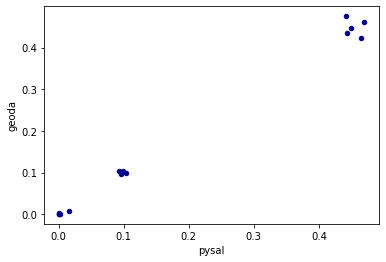

In [24]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results_case2.p_sim, GeoDa_LJC.PP_VAL_C2).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

# Next steps
 
- Ensure docstrings include all relevant information and formatting


# Planning out some `unittest`

In [28]:
# based off: https://github.com/pysal/esda/blob/master/tests/test_join_counts.py
import unittest
import numpy as np
from libpysal.weights.util import lat2W
from libpysal.common import pandas

PANDAS_EXTINCT = pandas is None

class Local_Join_Counts_Tester(unittest.TestCase):
    """Unit test for Local Join Counts (univariate)"""
    def setUp(self):
        self.w = lat2W(4, 4)
        self.x = np.ones(16)
        self.x[0:8] = 0
        self.z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]

    def test_Local_Join_Counts(self):
            """Test method"""
            np.random.seed(12345)
            ljc_bv_case1 = Local_Join_Count_BV(connectivity=self.w).fit(self.x, self.z, case="BJC")
            ljc_bv_case2 = Local_Join_Count_BV(connectivity=self.w).fit(self.x, self.z, case="CLC")
            self.assertAlmostEqual(ljc_bv_case1.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])
            self.assertAlmostEqual(ljc_bv_case2.LJC, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2])
            